# 0. Pre-Processing

### 0.1. Mount Drive

In [0]:
# upload dataset to Google Drive and connect Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 0.2. Install Dependencies

In [0]:
# you may need to restart runtime after installation
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-rwcr8ybb
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-rwcr8ybb
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-jbxvem52
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-jbxvem52
     |████████████████████████████████| 266kB 34.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=34040 sha256=05a94aba80c79fb4b36afaf824a05791d3bcaeef041e330f814600137ba552dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-8czle6go/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

### 0.3. Import Modules

In [0]:
import torch, torchvision
import numpy as np
import pandas as pd
import random
import json
import cv2
import os

import detectron2
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()

import itertools
from itertools import groupby
from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskutil
from pycocotools import mask as maskUtils

# 1. Create Dataset Instance

In [0]:
# register training and test datasets to Detectron2
register_coco_instances("T", {}, "/content/gdrive/My Drive/pascal_train.json", "/content/gdrive/My Drive/train_images")
register_coco_instances("V", {}, "/content/gdrive/My Drive/test.json", "/content/gdrive/My Drive/valid_images")

# metadata
train_metadata = MetadataCatalog.get("T")
test_metadata = MetadataCatalog.get("V")

# dataset dictionary
train_dataset_dicts = DatasetCatalog.get("T")
test_dataset_dicts = DatasetCatalog.get("V")

[12/19 11:30:39 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/gdrive/My Drive/pascal_train.json
[12/19 11:30:41 d2.data.datasets.coco]: Loading /content/gdrive/My Drive/test.json takes 1.79 seconds.
[12/19 11:30:41 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/gdrive/My Drive/test.json


### 1.1. Visualize if images are correctly loaded

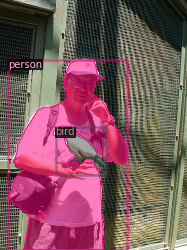

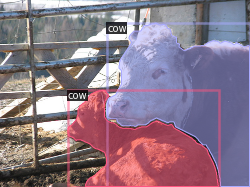

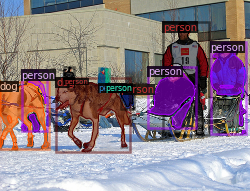

In [0]:
for d in random.sample(train_dataset_dicts, 3):
    image = cv2.imread(d["file_name"])
    visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 2. Train Detectron2

### 2.1. Define Training Configuration

In [0]:
cfg = get_cfg()

# load ImageNet pretrained weights
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# load dataset
cfg.DATASETS.TRAIN = ("T")

# parameters
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000                       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20             

WARNING [12/19 11:30:54 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


### 2.2. Train the Model

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/19 09:29:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:05, 17.5MB/s]                           


[12/19 09:29:35 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_beta           of shape (64,)
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_running_mean   of shape (64,)
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_running_var    of shape (64,)
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_gamma          of shape (64,)
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (64, 64, 1, 1)
[12/19 09:29:35 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv2.norm.bias         

# 5. Compute Results

### 5.1. Define configuration

In [0]:
# load weights
cfg.MODEL.WEIGHTS = "/content/gdrive/My Drive/model_final.pth"

# define min score threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# choose dataset
cfg.DATASETS.TEST = ("V")

# load training annotations
coco = COCO('/content/gdrive/My Drive/pascal_train.json') 

# save categories
CLASS_NAMES = [coco.cats[k]['name'] for k in coco.cats.keys()]

# metadata
test_metadata.set(thing_classes=CLASS_NAMES)

# define predictor
predictor = DefaultPredictor(cfg)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


### 5.2. Make predictions

In [0]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

# load test annotations
cocoGt = COCO("/content/gdrive/My Drive/test.json")

# store results
coco_dt = []

for imgid in cocoGt.imgs:
    # read test image
    image = cv2.imread("/content/gdrive/My Drive/valid_images/" + cocoGt.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1]

    # make prediction
    outputs = predictor(image)

    # parse prediction
    boxes = (outputs['instances']._fields['pred_boxes'].tensor).cpu().numpy()
    scores = (outputs['instances']._fields['scores']).cpu().numpy()
    categories = (outputs['instances']._fields['pred_classes']).cpu().numpy()
    masks = (outputs['instances']._fields['pred_masks']).cpu().numpy()
    n_instances = len(scores)
    if len(categories) > 0:
        for i in range(n_instances):
            pred = {}
            pred['image_id'] = imgid
            pred['category_id'] = int(categories[i]) + 1
            pred['segmentation'] = binary_mask_to_rle(masks[i,:,:])
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 5.3. Output JSON file

In [0]:
with open('0845086_25.json', 'w') as f:
    f.write(pd.Series(coco_dt).to_json(orient='values'))
f.close()

### 5.4. Visualize Prediction

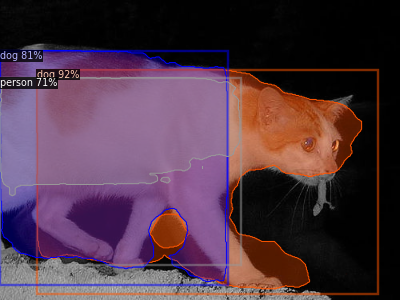

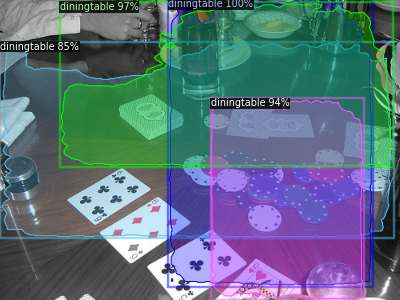

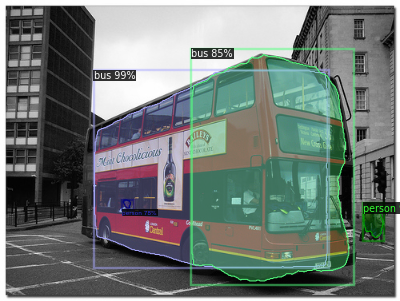

In [0]:
cfg.MODEL.WEIGHTS = '/content/gdrive/My Drive/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST = ("V")
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 3):    
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])